In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import sys
from matplotlib.patches import Rectangle
from data_process import Data_processing
from netCDF4 import Dataset
# from cartopy_plot import visualization as vs

In [3]:
path = '/home/inhye_yoo/edu/datasets/'
name = 'ERA.sst.1950_2019.nc'

In [4]:
p = Data_processing(path+ name)
result, sst = p.get_data('p','199712')

#sst 아노말리
climatology = np.nanmean(result, axis=0)
anom = result - climatology
target = anom[47,11,:,:]

masked_data = np.where(target < 0.5, np.nan, target)
# target_flat = target.flatten() #1D로 변환
# neg_loc = np.argwhere(target < 0.5).reshape(-1)
# masked_data = np.delete(target_flat, neg_loc, axis=0)

/tmp/ipykernel_1679135/408335171.py:5: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(result, axis=0)


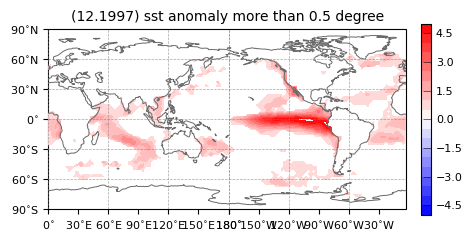

In [5]:
cmap = plt.colormaps['bwr']
clevs = np.arange(-5.0, 5.001, 0.5)
vm = 5.0
vn = -5.0

# make grid / 위도-경도 좌표를 생성하고, 지도 좌표계를 설정하며, 격자선을 추가하는 부분
x, y = np.meshgrid(np.arange(0, 360.0, 2.5), np.arange(-90, 92.5, 2.5))
fig = plt.figure(figsize=(11, 8.5))
ax = fig.add_subplot(2,2,1, projection = ccrs.PlateCarree(central_longitude=180.0))
grd = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                    linewidth=0.5, linestyle='dashed', color='gray', alpha=0.7, zorder=7)

# 경도, 위도 눈금을 30도 간격으로 생성
lon_ticks = np.arange(-180,181, 30)
lat_ticks = np.arange(-90, 91, 30)

# 위도 눈금 위치 설정
grd.ylocator = mticker.FixedLocator(lat_ticks)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

# 경도 및 위도 눈금 포맷 설정
lon_fmt = LongitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
lat_fmt = LatitudeFormatter(number_format='.0f', degree_symbol=r'$^{\circ}$')
ax.xaxis.set_major_formatter(lon_fmt)
ax.yaxis.set_major_formatter(lat_fmt)
plt.setp(ax.get_xticklabels(), fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)

# 해안선 따하 선긋기
ax.coastlines(linewidth=0.7, color='dimgray',zorder=7)
plt.title('(12.1997) sst anomaly more than 0.5 degree', loc='center', fontsize=10)

# 첫번째 아노말리 그래프
cax = plt.contourf(x, y, masked_data, levels=clevs, cmap=cmap, transform=ccrs.PlateCarree(), zorder=4)

# 컬러바의 위치와 크기 서라정
cbar = plt.colorbar(cax, orientation='vertical', fraction=0.025, pad=0.04)
cbar.ax.tick_params(labelsize=8, direction='in', length=6, width=0.4, color='black', zorder=6)

plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace=0.1, wspace=0.3)
plt.show()
plt.savefig(path+name+'.png', dpi=300)
plt.close()


(29, 73, 144)
nan


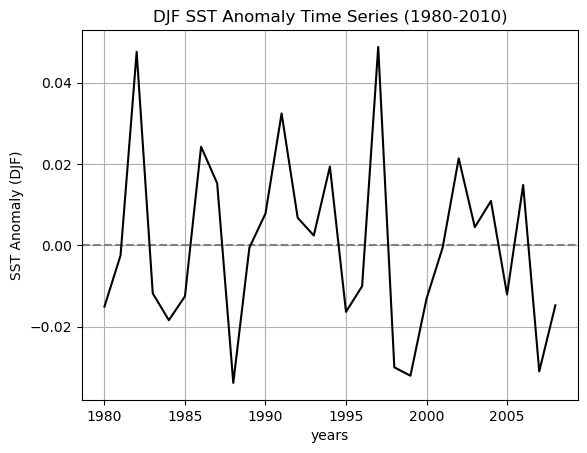

In [6]:
# 1980년 1월 ~ 2010년 12월
sst_anom = anom[30:60,:,:,:]

nino34 = np.append(sst_anom[:-1], sst_anom[1:], axis=1)
djf_nino34 = np.mean(nino34[:,11:14], axis=1)

print(djf_nino34.shape)
# 지역평균
lat = np.arange(-90, 92.5, 2.5) #위도 배열 생성
lat = np.cos(np.radians(lat))
lat = np.full_like(djf_nino34, lat[np.newaxis,..., np.newaxis])
lat = np.where(np.isnan(djf_nino34)==True, np.nan, lat)

pick_dat = djf_nino34[:,34:39, 76:97]
pick_lat = lat[:, 34:39, 76:97]
idx = np.nansum(pick_dat * pick_lat, axis=(1,2))/ np.nansum(lat, axis=(1,2))

djf_std = np.std(idx, axis=0)
djf_std = np.where(djf_std <= 1,np.nan, djf_std)
print(djf_std)

years = np.arange(1980, 2009)

plt.ylabel('SST Anomaly (DJF)')
plt.xlabel('years')
plt.title('DJF SST Anomaly Time Series (1980-2010)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.plot(years, idx, color='black')
# plt.plot(years,djf_std, color='red')
plt.show()

<h3>겨울철 Nino3.4가 0.5 이상 일 때 봄철 SST composite를 구하시오.</h3>

In [42]:
# 데이터 가져오기져오기
f = Dataset(path + name, 'r')
f.set_auto_mask(False)

sst = f.variables['p'][:]
# print(sst.shape)

sst = sst.reshape(-1,12,73,144)
sst = np.where(sst==-9.99e+08, np.nan, sst)

# anomaly 구하기
climatology = np.nanmean(sst, axis=0)
sst_anom = sst - climatology

# DJF SST 슬라이싱
djf_sst = np.append(sst_anom[:-1],sst_anom[1:], axis=1)
djf_sst = np.nanmean(djf_sst[:,11:14], axis=0)

# Nino3.4 index 구하기
# 지역평균
lat = np.arange(-90, 92.5, 2.5) # 위도 배열 생성
lat = np.cos(np.radians(lat))
lat = np.full_like(sst_anom, lat[np.newaxis, ..., np.newaxis])
lat = np.where(np.isnan(sst_anom), np.nan, lat)

# nino3.4
pick_dat = sst_anom[:,:, 34:39, 76:97]
pick_lat = lat[:,:, 34:39, 76:97]
idx = np.nansum(pick_dat * pick_lat, axis=(1,2))/np.nansum(pick_lat, axis=(1,2))

# djf nino3.4가 0.5보다 작았을 때, year 뽑기
neg_loc = np.argwhere(idx < 0.5).reshape(-1)

# 봄철(3-5월) SST 슬라이싱
mam_sst = np.nanmean(sst_anom[:,2:5,:,:], axis=1)

# 전체 mam(year)에서 (1)에서 뽑은 year 지우기
# 그 다음 평균하기
el_comp = np.mean(np.delete(mam_sst, neg_loc, axis=0), axis=0)
el_comp = np.array(el_comp)


/tmp/ipykernel_1679135/1854272323.py:12: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(sst, axis=0)
/tmp/ipykernel_1679135/1854272323.py:17: RuntimeWarning: Mean of empty slice
  djf_sst = np.nanmean(djf_sst[:,11:14], axis=0)
/tmp/ipykernel_1679135/1854272323.py:35: RuntimeWarning: Mean of empty slice
  mam_sst = np.nanmean(sst_anom[:,2:5,:,:], axis=1)


<h3>3번 코드 시각화</h3>